In [1]:
from IPython.display import display

import torch
from torch import nn
from torch.nn import functional

torch.set_printoptions(sci_mode=False)
torch.set_default_tensor_type('torch.FloatTensor')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Net(nn.Module):
    def __init__(self, n_channels):
        super(Net, self).__init__()
        
        self.n_channels = n_channels

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.n_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(n_channels, n_channels*2, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(n_channels*2, n_channels*4, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(self.n_channels*4*8*8, self.n_channels*4) # Entrada la salida de n_dims de foward
        self.fc2 = nn.Linear(self.n_channels*4, 6)

    def forward(self, x):
        # Empieza 3x64x64
        x = self.conv1(x) # n_channels x 64 x 64
        x = functional.relu(functional.max_pool2d(x, 2)) # max_pool divide dimension de imagen | n_chanels x 32 x 32
        
        x = self.conv2(x) # n_channels*2 x 32 x 32
        x = functional.relu(functional.max_pool2d(x, 2)) # n_chanels*2 x 16 x 16
        
        x = self.conv3(x) # n_channels*4 x 16 x 16
        x = functional.relu(functional.max_pool2d(x, 2)) # n_chanels*4 x 8 x 8

        # Flatten, aplanar datos a una dimension
        x = x.view(-1, self.n_channels*4*8*8)
        
        # Fully Connected (FC)
        x = self.fc1(x) # out=n_cannels*4
        x = functional.relu(x) 
        x = self.fc2(x) # Salida cantidad de clases a predecir

        # log_SoftMax
        x = functional.log_softmax(x, dim=1) # Salida en forma de probabilidad

        return x

In [3]:
import sys
sys.path.append('..')

from plot_helpers import imshow

import os 
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [4]:
class SignsDataset(Dataset):
    def __init__(self, base_dir, split_name='train', transform=None):
        path = os.path.join(base_dir, '{}_signs'.format(split_name))
        files = os.listdir(path)

        self.filenames = [ os.path.join(path, file) for file in files if file.endswith('.jpg') ]
        self.targets = [ int(file[0]) for file in files ]
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        image = Image.open(self.filenames[index])
        image = self.transform(image) if self.transform else image
        return image, self.targets[index]



864

0

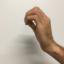

In [5]:
signs = SignsDataset('../datasets/64x64_SIGNS')

display(len(signs))
display(signs[0][1])
display(signs[0][0])

In [6]:
from torchvision import transforms

train_set = SignsDataset('../datasets/64x64_SIGNS', split_name='train', transform=transforms.ToTensor())
dataloader = DataLoader(train_set, batch_size=32, shuffle=True)

tensor([5, 4, 0, 2, 2, 2, 4, 3, 4, 5, 1, 2, 4, 5, 1, 0, 1, 1, 5, 4, 5, 4, 1, 2,
        1, 3, 4, 1, 5, 2, 2, 3])


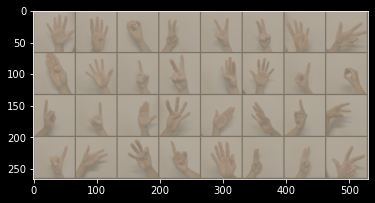

In [7]:
from torchvision.utils import make_grid

for inputs, targets in dataloader:
    print(targets)
    out = make_grid(inputs)
    imshow(out)
    break

In [8]:
from torch import optim


In [9]:
net = Net(32).to(device)

loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [10]:
class RunningMetric():
    def __init__(self):
        self.summatory = 0
        self.n_data = 0

    def update(self, val, size):
        self.summatory += val
        self.n_data += size 

    def __call__(self):
        return self.summatory/float(self.n_data)

In [11]:
n_epochs = 100

for epoch in range(n_epochs):
    print(f'Epoch {epoch+1}/{n_epochs}')
    print('_'*10, '\n')

    running_loss = RunningMetric() # perdida
    running_acc = RunningMetric() # precision

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = loss_fn(outputs, targets)

        loss.backward() # magias: gradientes calculados automaticamente
        optimizer.step() # magia2: actualiza las pesos

        batch_size = inputs.size()[0]
        running_loss.update(loss.item()*batch_size, batch_size)
        running_acc.update(torch.sum(preds == targets).float(), batch_size)

    print( 'Loss:  {:.4f}      Acc: {:.3%}'.format(running_loss(), running_acc()) )


Epoch 1/100
__________ 

Loss:  1.7939      Acc: 16.319%
Epoch 2/100
__________ 

Loss:  1.7926      Acc: 16.435%
Epoch 3/100
__________ 

Loss:  1.7911      Acc: 20.255%
Epoch 4/100
__________ 

Loss:  1.7910      Acc: 21.528%
Epoch 5/100
__________ 

Loss:  1.7902      Acc: 17.245%
Epoch 6/100
__________ 

Loss:  1.7896      Acc: 18.403%
Epoch 7/100
__________ 

Loss:  1.7892      Acc: 17.361%
Epoch 8/100
__________ 

Loss:  1.7887      Acc: 20.486%
Epoch 9/100
__________ 

Loss:  1.7879      Acc: 17.361%
Epoch 10/100
__________ 

Loss:  1.7872      Acc: 17.245%
Epoch 11/100
__________ 

Loss:  1.7864      Acc: 19.329%
Epoch 12/100
__________ 

Loss:  1.7857      Acc: 21.759%
Epoch 13/100
__________ 

Loss:  1.7848      Acc: 28.356%
Epoch 14/100
__________ 

Loss:  1.7838      Acc: 23.843%
Epoch 15/100
__________ 

Loss:  1.7829      Acc: 22.454%
Epoch 16/100
__________ 

Loss:  1.7817      Acc: 30.440%
Epoch 17/100
__________ 

Loss:  1.7800      Acc: 27.546%
Epoch 18/100
__________